In [3]:
# Importing important modules
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier


import re
import math

import pickle
from tqdm import tqdm
import os
from collections import Counter

In [4]:
from google.colab import drive

drive.mount("/content/Drive")

Mounted at /content/Drive


# Data Loading

In [5]:
data = pd.read_csv('/content/Drive/MyDrive/cleaned_data.csv')

In [6]:
data.shape

(109248, 10)

In [7]:
data.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,0,0,students english learners working english seco...,154.60,23
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,7,1,students arrive school eager learn polite gene...,299.00,1
2,ms,az,grades_6_8,health_sports,health_wellness_teamsports,1,0,true champions not always ones win guts mia ha...,516.85,22
3,mrs,ky,grades_prek_2,literacy_language_math_science,literacy_mathematics,4,1,work unique school filled esl english second l...,232.90,4
4,mrs,tx,grades_prek_2,math_science,mathematics,1,1,second grade classroom next year made around 2...,67.98,4


# Adding sentiment score

In [8]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [9]:
neg = []
neu = []
pos = []
comp = []

sid = SentimentIntensityAnalyzer()

for sentence in data['essay']:
    ss = sid.polarity_scores(sentence)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])

data['Neg'] = neg
data['Neu'] = neu
data['Pos'] = pos
data['Compound'] = comp

# Train Test Split

In [10]:
y = data['project_is_approved']
X = data.drop(['project_is_approved'], axis=1)

In [11]:
X.shape, y.shape

((109248, 13), (109248,))

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((76473, 13), (32775, 13), (76473,), (32775,))

# 1. Data preprocessing

## 1.1 Encoding essay

### 1.1.1 TFIDF

In [14]:
print('Before Vectorization')
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

# defining tfidf vectorizor
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=50000)
# training
vectorizer.fit(X_train['essay'].values)

# tranforming train data and test data
x_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
x_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print('-'*50)
print('After Vectorization')
print(x_train_essay_tfidf.shape, y_train.shape)
print(x_test_essay_tfidf.shape, y_test.shape)

Before Vectorization
(76473, 13) (76473,)
(32775, 13) (32775,)
--------------------------------------------------
After Vectorization
(76473, 50000) (76473,)
(32775, 50000) (32775,)


### 1.1.2. BOW

In [ ]:
print('Before Vectorization')
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=50000)
vectorizer.fit(X_train['essay'].values)

x_train_essay_bow = vectorizer.transform(X_train['essay'].values)
x_test_essay_bow = vectorizer.transform(X_test['essay'].values)

print('-'*50)
print('After Vectorization')
print(x_train_essay_bow.shape, y_train.shape)
print(x_test_essay_bow.shape, y_test.shape)

Before Vectorization
(76473, 13) (76473,)
(32775, 13) (32775,)
--------------------------------------------------
After Vectorization
(76473, 50000) (76473,)
(32775, 50000) (32775,)


### 1.1.3 TFIDF_W2V

In [17]:
with open('/content/Drive/MyDrive/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [18]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [19]:
train_tfidf_w2v_vectors = []
for sentence in tqdm(X_train['essay'].values):
    vector = np.zeros(300)
    tfidf_weight = 0
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += vec*tf_idf
            tfidf_weight += tf_idf
    if tf_idf != 0:
        vector/tfidf_weight
    train_tfidf_w2v_vectors.append(vector)

print(len(train_tfidf_w2v_vectors))
print(len(train_tfidf_w2v_vectors[0]))

100%|██████████| 76473/76473 [02:08<00:00, 597.07it/s]

76473
300


In [20]:
test_tfidf_w2v_vectors = []
for sentence in tqdm(X_test['essay'].values):
    vector = np.zeros(300)
    tfidf_weight = 0
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += vec*tf_idf
            tfidf_weight += tf_idf
    if tf_idf != 0:
        vector/tfidf_weight
    test_tfidf_w2v_vectors.append(vector)

print(len(test_tfidf_w2v_vectors))
print(len(test_tfidf_w2v_vectors[0]))

100%|██████████| 32775/32775 [00:55<00:00, 594.23it/s]

32775
300


## 1.2 Encoding School_state

In [21]:
# defining bow vectorizor
vectorizer = CountVectorizer()
#training
vectorizer.fit(X_train['school_state'].values)

# tranforming train data and test data
x_train_states_ohe = vectorizer.transform(X_train['school_state'].values)
x_test_states_ohe = vectorizer.transform(X_test['school_state'].values)

print(x_train_states_ohe.shape, y_train.shape)
print(x_test_states_ohe.shape, y_test.shape)

(76473, 51) (76473,)
(32775, 51) (32775,)


## 1.3 Encoding prefix

In [22]:
# defining bow vectorizor
vectorizer = CountVectorizer()
#training
vectorizer.fit(X_train['teacher_prefix'].values)

# tranforming train data and test data
x_train_teacher_prefix_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
x_test_teacher_prefix_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print(x_train_teacher_prefix_ohe.shape, y_train.shape)
print(x_test_teacher_prefix_ohe.shape, y_test.shape)

(76473, 5) (76473,)
(32775, 5) (32775,)


## 1.4 Encoding project_grade_category

In [23]:
# defining bow vectorizor
vectorizer = CountVectorizer()
#training
vectorizer.fit(X_train['project_grade_category'].values)

# tranforming train data and test data
x_train_pgc_ohe = vectorizer.transform(X_train['project_grade_category'].values)
x_test_pgc_ohe = vectorizer.transform(X_test['project_grade_category'].values)


print(x_train_pgc_ohe.shape, y_train.shape)
print(x_test_pgc_ohe.shape, y_test.shape)

(76473, 4) (76473,)
(32775, 4) (32775,)


## 1.5 Encoding project_subject_categories

In [24]:
# defining bow vectorizor
vectorizer = CountVectorizer()
#training
vectorizer.fit(X_train['project_subject_categories'].values)

# tranforming train data and test data
x_train_category_ohe = vectorizer.transform(X_train['project_subject_categories'].values)
x_test_category_ohe = vectorizer.transform(X_test['project_subject_categories'].values)

print(x_train_category_ohe.shape, y_train.shape)
print(x_test_category_ohe.shape, y_test.shape)

(76473, 51) (76473,)
(32775, 51) (32775,)


## 1.6 Encoding project_subject_subcategories

In [25]:
# defining bow vectorizor
vectorizer = CountVectorizer()
#training
vectorizer.fit(X_train['project_subject_subcategories'].values)

# tranforming train data and test data
x_train_subcategory_ohe = vectorizer.transform(X_train['project_subject_subcategories'].values)
x_test_subcategory_ohe = vectorizer.transform(X_test['project_subject_subcategories'].values)


print(x_train_subcategory_ohe.shape, y_train.shape)
print(x_test_subcategory_ohe.shape, y_test.shape)

(76473, 393) (76473,)
(32775, 393) (32775,)


## 1.7 MinMaxScaler Price

In [26]:
from sklearn.preprocessing import MinMaxScaler
# defining column normalizer
scaler = MinMaxScaler()
#training
scaler.fit(X_train['price'].values.reshape(-1,1))

#tranforming train data and test data
x_train_price = scaler.transform(X_train['price'].values.reshape(-1,1))
x_test_price = scaler.transform(X_test['price'].values.reshape(-1,1))

## 1.8 MinMaxScaler teacher_number_of_previously_posted_projects

In [27]:
# defining column normalizer
scaler = MinMaxScaler()
#training
scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

#tranforming train data and test data
x_train_previous_posts = scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_test_previous_posts = scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

## 1.9 MinMaxScaler Quantity

In [28]:
# defining column normalizer
scaler = MinMaxScaler()
#training
scaler.fit(X_train['quantity'].values.reshape(-1,1))

#tranforming train data and test data
x_train_quantity = scaler.transform(X_train['quantity'].values.reshape(-1,1))
x_test_quantity = scaler.transform(X_test['quantity'].values.reshape(-1,1))

## 1.10 MinMaxScaler Neg

In [29]:
# defining column normalizer
scaler = MinMaxScaler()
#training
scaler.fit(X_train['Neg'].values.reshape(-1,1))

#tranforming train data and test data
x_train_neg = scaler.transform(X_train['Neg'].values.reshape(-1,1))
x_test_neg = scaler.transform(X_test['Neg'].values.reshape(-1,1))

## 1.11 MinMaxScaler Neu

In [30]:
# defining column normalizer
scaler = MinMaxScaler()
#training
scaler.fit(X_train['Neu'].values.reshape(-1,1))

#tranforming train data and test data
x_train_neu = scaler.transform(X_train['Neu'].values.reshape(-1,1))
x_test_neu = scaler.transform(X_test['Neu'].values.reshape(-1,1))

## 1.12 MinMaxScaler Pos

In [31]:
# defining column normalizer
scaler = MinMaxScaler()
#training
scaler.fit(X_train['Pos'].values.reshape(-1,1))

#tranforming train data and test data
x_train_pos = scaler.transform(X_train['Pos'].values.reshape(-1,1))
x_test_pos = scaler.transform(X_test['Pos'].values.reshape(-1,1))

## 1.13 MinMaxScaler Comp

In [32]:
# defining column normalizer
scaler = MinMaxScaler()
#training
scaler.fit(X_train['Compound'].values.reshape(-1,1))

#tranforming train data and test data
x_train_comp = scaler.transform(X_train['Compound'].values.reshape(-1,1))
x_test_comp = scaler.transform(X_test['Compound'].values.reshape(-1,1))

# 2 Merging all processed features

## 2.1. Merging all encoded features considering tfidf representation of text features.

In [33]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_train_tfidf = hstack((x_train_essay_tfidf, x_train_states_ohe, x_train_teacher_prefix_ohe, x_train_pgc_ohe, x_train_category_ohe, x_train_subcategory_ohe, x_train_price, x_train_previous_posts, x_train_quantity, x_train_neg, x_train_neu, x_train_pos, x_train_comp)).tocsr()
X_test_tfidf = hstack((x_test_essay_tfidf, x_test_states_ohe, x_test_teacher_prefix_ohe, x_test_pgc_ohe, x_test_category_ohe, x_test_subcategory_ohe, x_test_price, x_test_previous_posts, x_test_quantity, x_test_neg, x_test_neu, x_test_pos, x_test_comp)).tocsr()

print("Final Data matrix")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

Final Data matrix
(76473, 50511) (76473,)
(32775, 50511) (32775,)


## 2.2 Merging all encoded features considering BOW representation of text features.

In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_train_bow = hstack((x_train_essay_bow, x_train_states_ohe, x_train_teacher_prefix_ohe, x_train_pgc_ohe, x_train_category_ohe, x_train_subcategory_ohe, x_train_price, x_train_previous_posts, x_train_quantity, x_train_neg, x_train_neu, x_train_pos, x_train_comp)).tocsr()
X_test_bow = hstack((x_test_essay_bow, x_test_states_ohe, x_test_teacher_prefix_ohe, x_test_pgc_ohe, x_test_category_ohe, x_test_subcategory_ohe, x_test_price, x_test_previous_posts, x_test_quantity, x_test_neg, x_test_neu, x_test_pos, x_test_comp)).tocsr()

print("Final Data matrix")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

Final Data matrix
(76473, 50508) (76473,)
(32775, 50508) (32775,)


## 2.3 Merging all encoded features considering BOW representation of text features.

In [34]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_train_w2v = hstack((train_tfidf_w2v_vectors, x_train_states_ohe, x_train_teacher_prefix_ohe, x_train_pgc_ohe, x_train_category_ohe, x_train_subcategory_ohe, x_train_price, x_train_previous_posts, x_train_quantity, x_train_neg, x_train_neu, x_train_pos, x_train_comp)).tocsr()
X_test_w2v = hstack((test_tfidf_w2v_vectors, x_test_states_ohe, x_test_teacher_prefix_ohe, x_test_pgc_ohe, x_test_category_ohe, x_test_subcategory_ohe, x_test_price, x_test_previous_posts, x_test_quantity, x_test_neg, x_test_neu, x_test_pos, x_test_comp)).tocsr()

print("Final Data matrix")
print(X_train_w2v.shape, y_train.shape)
print(X_test_w2v.shape, y_test.shape)

Final Data matrix
(76473, 811) (76473,)
(32775, 811) (32775,)


# 3. Modeling

## 3.1 Naive Bayes

### 3.1.1 with tfidf representation

In [ ]:
# hyperparameter tuning
naive = MultinomialNB()
parameters = {'alpha':[0.01,0.1,0.5,1,5,10,20,30,40,50,100,500]}
clf = GridSearchCV(naive, parameters, cv=3, scoring='roc_auc', return_train_score=True)
clf.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 0.5, 1, 5, 10, 20, 30, 40, 50,
                                   100, 500]},
             return_train_score=True, scoring='roc_auc')

In [ ]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.158588,0.007951,0.051397,0.007983,0.01,{'alpha': 0.01},0.677461,0.674121,0.660882,0.670821,0.007159,1,0.854345,0.847309,0.841063,0.847572,0.005425
1,0.162168,0.015055,0.048006,0.003824,0.1,{'alpha': 0.1},0.676926,0.674493,0.660237,0.670552,0.007361,2,0.840791,0.832702,0.826503,0.833332,0.005850
2,0.154782,0.014851,0.051794,0.004119,0.5,{'alpha': 0.5},0.666970,0.665985,0.650454,0.661136,0.007564,3,0.805078,0.796153,0.790908,0.797380,0.005850
3,0.148756,0.021102,0.069198,0.016256,1,{'alpha': 1},0.655921,0.654768,0.640209,0.650299,0.007151,4,0.774398,0.766050,0.762170,0.767539,0.005102
4,0.149432,0.032227,0.049395,0.005290,5,{'alpha': 5},0.624556,0.617222,0.609624,0.617134,0.006096,5,0.680422,0.677906,0.677652,0.678660,0.001250
5,0.160264,0.011824,0.057491,0.015851,10,{'alpha': 10},0.612433,0.600712,0.597089,0.603411,0.006548,6,0.643186,0.644031,0.644358,0.643858,0.000494
6,0.154031,0.014000,0.046392,0.002579,20,{'alpha': 20},0.599930,0.584874,0.584854,0.589886,0.007102,7,0.612514,0.616277,0.616445,0.615079,0.001815
7,0.155952,0.005522,0.052869,0.004945,30,{'alpha': 30},0.592656,0.576042,0.577843,0.582180,0.007444,8,0.597708,0.602847,0.602678,0.601078,0.002384
8,0.151066,0.026223,0.044944,0.002907,40,{'alpha': 40},0.587527,0.569982,0.572851,0.576787,0.007685,9,0.588306,0.594307,0.593843,0.592152,0.002726
9,0.149998,0.021107,0.047669,0.003008,50,{'alpha': 50},0.583562,0.565392,0.568952,0.572635,0.007862,10,0.581540,0.588139,0.587425,0.585701,0.002957


#### Class_prior=None

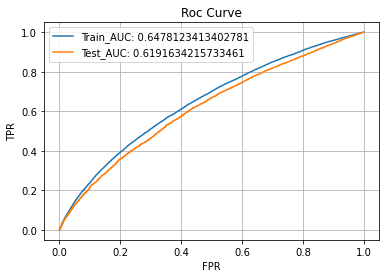

In [ ]:
best_naive = MultinomialNB(alpha=10)
best_naive.fit(X_train_tfidf,y_train)
    
# probability score of training and test data
y_train_prob_pred = best_naive.predict_proba(X_train_tfidf)[:,1]
y_test_prob_pred = best_naive.predict_proba(X_test_tfidf)[:,1]
    
# finding fpr, tpr, thresholds of training and test data
tr_fpr, tr_tpr, tr_theshold = roc_curve(y_train, y_train_prob_pred)
te_fpr, te_tpr, te_theshold = roc_curve(y_test, y_test_prob_pred)
    
    
# plotting fpr vs tpr curve
plt.plot(tr_fpr, tr_tpr, label = 'Train_AUC: '+str(auc(tr_fpr,tr_tpr)))
plt.plot(te_fpr, te_tpr, label = 'Test_AUC: '+str(auc(te_fpr,te_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Roc Curve")
plt.grid()
plt.show()

#### Class_prior=[0.5,0.5]

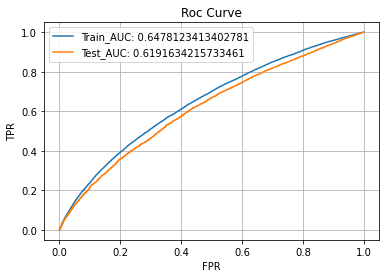

In [ ]:
best_naive = MultinomialNB(alpha=10, class_prior=[0.5,0.5])
best_naive.fit(X_train_tfidf,y_train)
    
# probability score of training and test data
y_train_prob_pred = best_naive.predict_proba(X_train_tfidf)[:,1]
y_test_prob_pred = best_naive.predict_proba(X_test_tfidf)[:,1]
    
# finding fpr, tpr, thresholds of training and test data
tr_fpr, tr_tpr, tr_theshold = roc_curve(y_train, y_train_prob_pred)
te_fpr, te_tpr, te_theshold = roc_curve(y_test, y_test_prob_pred)
    
    
# plotting fpr vs tpr curve
plt.plot(tr_fpr, tr_tpr, label = 'Train_AUC: '+str(auc(tr_fpr,tr_tpr)))
plt.plot(te_fpr, te_tpr, label = 'Test_AUC: '+str(auc(te_fpr,te_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Roc Curve")
plt.grid()
plt.show()

### 3.1.2 with BOW representation

In [ ]:
# hyperparameter tuning
naive = MultinomialNB()
parameters = {'alpha':[0.01,0.1,0.5,1,5,10,20,30,40,50,100,500]}
clf = GridSearchCV(naive, parameters, cv=3, scoring='roc_auc', return_train_score=True)
clf.fit(X_train_bow, y_train)

GridSearchCV(cv=3, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 0.5, 1, 5, 10, 20, 30, 40, 50,
                                   100, 500]},
             return_train_score=True, scoring='roc_auc')

In [ ]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.186472,0.002699,0.065856,0.013985,0.01,{'alpha': 0.01},0.691239,0.689639,0.683946,0.688275,0.003130,4,0.852289,0.848108,0.844653,0.848350,0.003122
1,0.144803,0.013661,0.044154,0.001336,0.1,{'alpha': 0.1},0.692337,0.690910,0.685255,0.689501,0.003058,1,0.848277,0.843662,0.840202,0.844047,0.003308
2,0.143104,0.017235,0.042539,0.000491,0.5,{'alpha': 0.5},0.692219,0.691142,0.685130,0.689497,0.003119,2,0.841901,0.836923,0.833450,0.837425,0.003468
3,0.229383,0.069610,0.075571,0.006979,1,{'alpha': 1},0.691604,0.690917,0.684532,0.689018,0.003184,3,0.836513,0.831350,0.827878,0.831914,0.003548
4,0.193732,0.019087,0.071278,0.022421,5,{'alpha': 5},0.686848,0.687674,0.680079,0.684867,0.003403,5,0.810187,0.804423,0.800829,0.805146,0.003855
5,0.148774,0.013133,0.054209,0.010612,10,{'alpha': 10},0.680543,0.681363,0.675148,0.679018,0.002757,6,0.785677,0.780645,0.776975,0.781099,0.003567
6,0.139727,0.014689,0.047367,0.007600,20,{'alpha': 20},0.638539,0.640444,0.636674,0.638553,0.001539,7,0.710177,0.712025,0.706110,0.709437,0.002471
7,0.148782,0.002234,0.049636,0.013798,30,{'alpha': 30},0.542134,0.542184,0.541154,0.541824,0.000474,8,0.569091,0.568087,0.568693,0.568624,0.000413
8,0.153205,0.021752,0.040566,0.001273,40,{'alpha': 40},0.507920,0.508266,0.506712,0.507632,0.000666,9,0.511886,0.510635,0.512602,0.511708,0.000813
9,0.138682,0.010411,0.060881,0.016659,50,{'alpha': 50},0.502005,0.502862,0.501826,0.502231,0.000452,10,0.503107,0.502719,0.503493,0.503106,0.000316


#### Class_prior=None

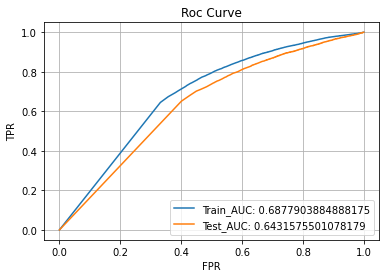

In [ ]:
best_naive = MultinomialNB(alpha=30)
best_naive.fit(X_train_bow,y_train)
    
# probability score of training and test data
y_train_prob_pred = best_naive.predict_proba(X_train_bow)[:,1]
y_test_prob_pred = best_naive.predict_proba(X_test_bow)[:,1]
    
# finding fpr, tpr, thresholds of training and test data
tr_fpr, tr_tpr, tr_theshold = roc_curve(y_train, y_train_prob_pred)
te_fpr, te_tpr, te_theshold = roc_curve(y_test, y_test_prob_pred)
    
    
# plotting fpr vs tpr curve
plt.plot(tr_fpr, tr_tpr, label = 'Train_AUC: '+str(auc(tr_fpr,tr_tpr)))
plt.plot(te_fpr, te_tpr, label = 'Test_AUC: '+str(auc(te_fpr,te_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Roc Curve")
plt.grid()
plt.show()

#### Class_prior=[0.5,0.5]

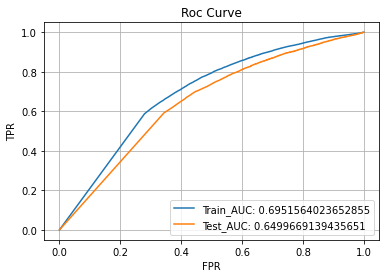

In [ ]:
best_naive = MultinomialNB(alpha=30, class_prior=[0.5,0.5])
best_naive.fit(X_train_bow,y_train)
    
# probability score of training and test data
y_train_prob_pred = best_naive.predict_proba(X_train_bow)[:,1]
y_test_prob_pred = best_naive.predict_proba(X_test_bow)[:,1]
    
# finding fpr, tpr, thresholds of training and test data
tr_fpr, tr_tpr, tr_theshold = roc_curve(y_train, y_train_prob_pred)
te_fpr, te_tpr, te_theshold = roc_curve(y_test, y_test_prob_pred)
    
    
# plotting fpr vs tpr curve
plt.plot(tr_fpr, tr_tpr, label = 'Train_AUC: '+str(auc(tr_fpr,tr_tpr)))
plt.plot(te_fpr, te_tpr, label = 'Test_AUC: '+str(auc(te_fpr,te_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Roc Curve")
plt.grid()
plt.show()

## 3.2 Decision Tree

### 3.2.1 with tfidf representation

In [36]:
max_depth = [1, 5, 10, 50]
min_samples_split = [5, 10, 100, 500]
dt = DecisionTreeClassifier()
param = {'max_depth':max_depth, 'min_samples_split':min_samples_split}
clf = RandomizedSearchCV(dt, param, scoring='roc_auc', cv=5, return_train_score=True, n_jobs=-1)
clf.fit(X_train_tfidf, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [1, 5, 10, 50],
                                        'min_samples_split': [5, 10, 100, 500]},
                   return_train_score=True, scoring='roc_auc')

In [37]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.636732,0.366111,0.035317,0.003423,5,1,"{'min_samples_split': 5, 'max_depth': 1}",0.572064,0.562013,0.572231,...,0.570003,0.003998,8,0.572426,0.574939,0.569305,0.572458,0.569420,0.571709,0.002123
1,11.456459,0.223555,0.033856,0.000979,5,5,"{'min_samples_split': 5, 'max_depth': 5}",0.666846,0.660508,0.663223,...,0.660675,0.005375,5,0.679927,0.678864,0.676160,0.677030,0.677946,0.677986,0.001326
2,11.432688,0.121947,0.034703,0.001428,10,5,"{'min_samples_split': 10, 'max_depth': 5}",0.666701,0.660580,0.663223,...,0.660648,0.005429,6,0.679927,0.678806,0.676160,0.676992,0.677927,0.677963,0.001324
3,30.886089,1.234819,0.037569,0.001456,10,10,"{'min_samples_split': 10, 'max_depth': 10}",0.674768,0.669865,0.675239,...,0.671490,0.007380,2,0.726269,0.719246,0.723950,0.718412,0.721911,0.721958,0.002915
4,27.995867,0.406844,0.036835,0.004091,500,10,"{'min_samples_split': 500, 'max_depth': 10}",0.675685,0.673831,0.678013,...,0.674029,0.007918,1,0.721373,0.713362,0.718753,0.710970,0.715950,0.716082,0.003706
5,154.214020,2.760368,0.040928,0.002604,500,50,"{'min_samples_split': 500, 'max_depth': 50}",0.634389,0.634575,0.624502,...,0.633577,0.005093,7,0.871901,0.853181,0.865057,0.882371,0.859090,0.866320,0.010152
6,2.283626,0.017240,0.035810,0.001724,100,1,"{'min_samples_split': 100, 'max_depth': 1}",0.572064,0.562013,0.572231,...,0.570003,0.003998,8,0.572426,0.574939,0.569305,0.572458,0.569420,0.571709,0.002123
7,11.575891,0.117437,0.037486,0.001672,100,5,"{'min_samples_split': 100, 'max_depth': 5}",0.666733,0.660580,0.663621,...,0.660718,0.005442,4,0.679791,0.678806,0.675903,0.676947,0.677927,0.677875,0.001363
8,31.304048,0.543841,0.036577,0.001666,5,10,"{'min_samples_split': 5, 'max_depth': 10}",0.673909,0.670779,0.674201,...,0.671214,0.007406,3,0.726929,0.719100,0.724849,0.719616,0.722112,0.722521,0.003005
9,186.667309,21.206431,0.040573,0.005703,5,50,"{'min_samples_split': 5, 'max_depth': 50}",0.553440,0.558263,0.537574,...,0.553851,0.008545,10,0.917328,0.905754,0.916342,0.934601,0.912696,0.917344,0.009537


In [38]:
print("Best Parameters are:\n",clf.best_params_)

Best Parameters are:
 {'min_samples_split': 500, 'max_depth': 10}


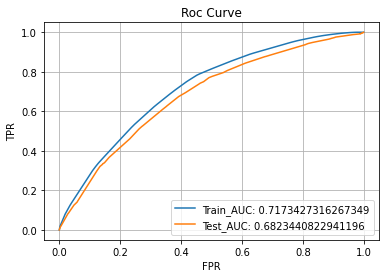

In [39]:
clf = DecisionTreeClassifier(max_depth=10, min_samples_split=500)
clf.fit(X_train_tfidf,y_train)

y_train_prob_pred = clf.predict_proba(X_train_tfidf)[:,1]
y_test_prob_pred = clf.predict_proba(X_test_tfidf)[:,1]

tr_fpr, tr_tpr, tr_theshold = roc_curve(y_train, y_train_prob_pred)
te_fpr, te_tpr, te_theshold = roc_curve(y_test, y_test_prob_pred)

plt.plot(tr_fpr, tr_tpr, label = 'Train_AUC: '+str(auc(tr_fpr,tr_tpr)))
plt.plot(te_fpr, te_tpr, label = 'Test_AUC: '+str(auc(te_fpr,te_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Roc Curve")
plt.grid()
plt.show()

### 3.2.2 Using TFIDF W2V text representation

In [40]:
from sklearn.model_selection import RandomizedSearchCV

max_depth = [1, 5, 10, 50]
min_samples_split = [5, 10, 100, 500]
dt = DecisionTreeClassifier()
param = {'max_depth':max_depth, 'min_samples_split':min_samples_split}
clf = RandomizedSearchCV(dt, param, scoring='roc_auc', cv=5, return_train_score=True, n_jobs=-1)
clf.fit(X_train_w2v, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [1, 5, 10, 50],
                                        'min_samples_split': [5, 10, 100, 500]},
                   return_train_score=True, scoring='roc_auc')

In [41]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,66.152531,10.042039,0.050767,0.017656,500,10,"{'min_samples_split': 500, 'max_depth': 10}",0.658350,0.658368,0.658632,...,0.658002,0.001864,3,0.743447,0.743826,0.741731,0.745239,0.746658,0.744180,0.001669
1,21.376724,0.314905,0.036180,0.000539,10,5,"{'min_samples_split': 10, 'max_depth': 5}",0.657552,0.660419,0.667779,...,0.662315,0.003666,1,0.681229,0.683691,0.680938,0.684444,0.684305,0.682921,0.001525
2,61.706703,1.487524,0.037751,0.001122,10,10,"{'min_samples_split': 10, 'max_depth': 10}",0.646773,0.641592,0.642000,...,0.642728,0.002265,6,0.778068,0.787692,0.779247,0.783277,0.783074,0.782272,0.003402
3,196.639998,5.534267,0.042163,0.004825,5,50,"{'min_samples_split': 5, 'max_depth': 50}",0.538129,0.545541,0.545770,...,0.542026,0.004907,10,0.999456,0.999508,0.999428,0.999497,0.999461,0.999470,0.000029
4,21.592026,0.696267,0.036696,0.000738,100,5,"{'min_samples_split': 100, 'max_depth': 5}",0.657481,0.660419,0.667779,...,0.662310,0.003692,2,0.681174,0.683691,0.680938,0.684309,0.684305,0.682883,0.001511
5,60.139058,0.907877,0.037087,0.000700,5,10,"{'min_samples_split': 5, 'max_depth': 10}",0.645768,0.640744,0.641231,...,0.642569,0.002171,7,0.778599,0.788779,0.780681,0.784214,0.784752,0.783405,0.003518
6,102.565458,7.637482,0.038840,0.002389,500,50,"{'min_samples_split': 500, 'max_depth': 50}",0.641099,0.646668,0.646754,...,0.645624,0.003361,4,0.795684,0.789021,0.794795,0.787925,0.792613,0.792008,0.003074
7,59.995072,0.932451,0.038496,0.001755,100,10,"{'min_samples_split': 100, 'max_depth': 10}",0.648377,0.642266,0.646031,...,0.644469,0.002858,5,0.766876,0.776152,0.768333,0.773560,0.772683,0.771521,0.003426
8,4.297003,0.056608,0.036563,0.001219,500,1,"{'min_samples_split': 500, 'max_depth': 1}",0.572064,0.562013,0.572231,...,0.570003,0.003998,9,0.572426,0.574939,0.569305,0.572458,0.569420,0.571709,0.002123
9,168.639605,16.650640,0.037935,0.003379,100,50,"{'min_samples_split': 100, 'max_depth': 50}",0.600056,0.597716,0.598164,...,0.598765,0.002602,8,0.920219,0.923681,0.922195,0.922170,0.920963,0.921846,0.001185


In [42]:
print("Best Parameters are:\n",clf.best_params_)

Best Parameters are:
 {'min_samples_split': 10, 'max_depth': 5}


In [43]:
best_depth = clf.best_params_['max_depth']
best_split = clf.best_params_['min_samples_split']

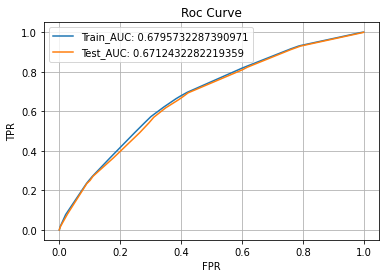

In [44]:
clf = DecisionTreeClassifier(max_depth=best_depth, min_samples_split=best_split)
clf.fit(X_train_tfidf,y_train)

y_train_prob_pred = clf.predict_proba(X_train_tfidf)[:,1]
y_test_prob_pred = clf.predict_proba(X_test_tfidf)[:,1]

tr_fpr, tr_tpr, tr_theshold = roc_curve(y_train, y_train_prob_pred)
te_fpr, te_tpr, te_theshold = roc_curve(y_test, y_test_prob_pred)

plt.plot(tr_fpr, tr_tpr, label = 'Train_AUC: '+str(auc(tr_fpr,tr_tpr)))
plt.plot(te_fpr, te_tpr, label = 'Test_AUC: '+str(auc(te_fpr,te_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Roc Curve")
plt.grid()
plt.show()

In [45]:
from prettytable import PrettyTable
# column names
table = PrettyTable(['Model','Vectorizor','Train AUC','Test AUC'])
# rows of the table
table.add_row(['Naive Bayes class_prior=None','TFIDF','0.6481','0.6191'])
table.add_row(['Naive Bayes class_prior=[0.5,0.5]','TFIDF','0.6478','0.6191'])
table.add_row(['Naive Bayes class_prior=None','BOW','0.6877', '0.6431'])
table.add_row(['Naive Bayes class_prior=[0.5,0.5]','BOW','0.6951','0.6499'])
table.add_row(['Decision Tree','TFIDF','0.7173','0.6823'])
table.add_row(['Decision Tree','TFIDF_w2v','0.6795', '0.6712'])

print(table)

+-----------------------------------+------------+-----------+----------+
|               Model               | Vectorizor | Train AUC | Test AUC |
+-----------------------------------+------------+-----------+----------+
|    Naive Bayes class_prior=None   |   TFIDF    |   0.6481  |  0.6191  |
| Naive Bayes class_prior=[0.5,0.5] |   TFIDF    |   0.6478  |  0.6191  |
|    Naive Bayes class_prior=None   |    BOW     |   0.6877  |  0.6431  |
| Naive Bayes class_prior=[0.5,0.5] |    BOW     |   0.6951  |  0.6499  |
|           Decision Tree           |   TFIDF    |   0.7173  |  0.6823  |
|           Decision Tree           | TFIDF_w2v  |   0.6795  |  0.6712  |
+-----------------------------------+------------+-----------+----------+
